### The model

$u(c) = log(c)$ utility function    
$y = 1$ Deterministic income    
$p(r = 0.02) = 0.5$   
$p(r = -0.02) = 0.5$ 

### value iteration 

In [1]:
# infinite horizon MDP problem
%pylab inline
import numpy as np
from scipy.optimize import minimize
def u(c):
    return np.log(c)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# discounting factor 
beta = 0.95
# wealth level
w_low = 0 
w_high = 10
# interest rate
r = 0.02
# deterministic income
y = 1
# good state and bad state economy with equal probability 0.5
# with good investment return 0.05 or bad investment return -0.05
ws = np.linspace(0.001,10**(1/2),100)**2
Vs = np.zeros(100)
Cs = np.zeros(100)

In [3]:
# Value iteration
for j in range(50):
    if j % 10 == 0:
        print(j)
    for i in range(len(ws)):
        w = ws[i]
        def obj(c):
            return -(u(c) + beta*(np.interp((y+w-c)*(1+r), ws, Vs) + np.interp((y+w-c)*(1-r), ws, Vs))/2)
        bounds = [(0.0001, y+w-0.0001)]
        res = minimize(obj, 0.0001, method='SLSQP', bounds=bounds)
        Cs[i] = res.x[0]
        Vs[i] = -res.fun

0
10
20
30
40


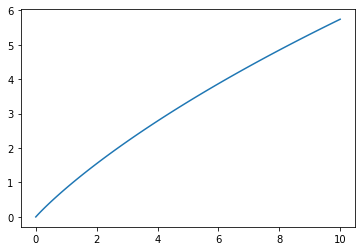

In [4]:
plt.plot(ws,Vs)

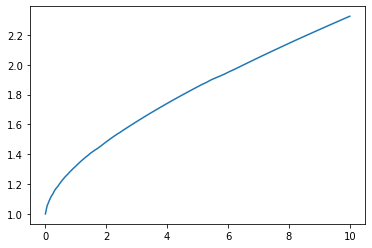

In [5]:
plt.plot(ws,Cs)

### policy gradient
Assume the policy form $\theta = (a,b,c, \sigma)$, then $\pi_\theta$ ~ $N(log(ax+b)+c, \sigma)$

Assume the initial value $a = 1$, $b = 1$, $c = 1$, $\sigma = 1$     


$$\theta_{k+1} = \theta_{k} + \alpha  \nabla_\theta V(\pi_\theta)|\theta_k$$

In [6]:
# simulation step T = 100
T = 20
def mu(theta, w):
    return np.log(theta[0] * w + theta[1]) + theta[2] 

def simSinglePath(theta):
    wPath = np.zeros(T)
    aPath = np.zeros(T)
    rPath = np.zeros(T)
    w = np.random.choice(ws)
    for t in range(T):
        c = np.random.normal(mu(theta, w), theta[3])
        while c < 0.0001 or c > w+y-0.0001:
            c = np.random.normal(mu(theta, w), theta[3])
        wPath[t] = w
        aPath[t] = c
        rPath[t] = np.log(c)*(beta**t)
        if np.random.uniform(0,1) > 0.5:
            w = (w+y-c) * (1+r)
        else:
            w = (w+y-c) * (1-r)
    return wPath, aPath, rPath


def gradientV(theta, D = 100):
    '''
        D is the sample size
    '''
    grad = np.zeros(len(theta))
    newGrad = np.zeros(len(theta))
    for d in range(D):
        wp, ap, rp = simSinglePath(theta) 
        newGrad[0] = np.sum((ap - mu(theta, wp))/(theta[3]**2)*(w/(theta[0]*w + theta[1])))
        newGrad[1] = np.sum((ap - mu(theta, wp))/(theta[3]**2)*(1/(theta[0]*w + theta[1])))
        newGrad[2] = np.sum((ap - mu(theta, wp))/(theta[3]**2))
        #newGrad[3] = np.sum((((ap - mu(theta, wp))**2 - theta[3]**2)/(theta[3]**3)))
        grad += newGrad * np.sum(rp)
    grad /= D
    grad[-1] = 0
    return grad

def updateTheta(theta):
    theta = theta + alpha * gradientV(theta)
    return theta 


import time
def plot(theta):
    def f(x):
        return np.log(theta[0]*x + theta[1]) + theta[2]
    plt.plot(ws, Cs, 'b')
    plt.plot(ws, f(ws), 'r')

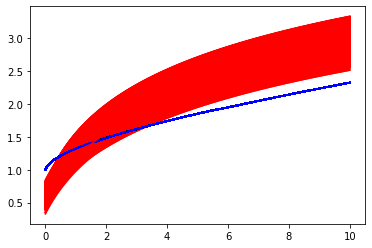

In [17]:
# c < 0 or c > w + 5, then reward -100
# initial theta 
theta = [1,1,1,0.1]
# gradient ascend step size 
alpha = 0.001
# store theta 
THETA = np.zeros((3,10000))
for i in range(10000):
    theta = updateTheta(theta)
    THETA[:,i] = theta[:3]
    plot(theta)

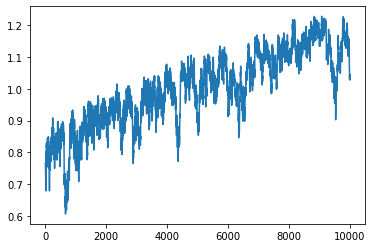

In [18]:
plt.plot(THETA[0,:])

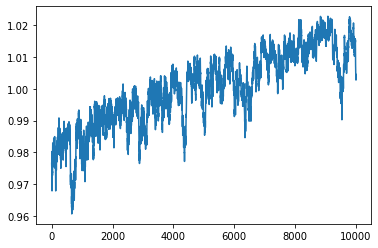

In [19]:
plt.plot(THETA[1,:])

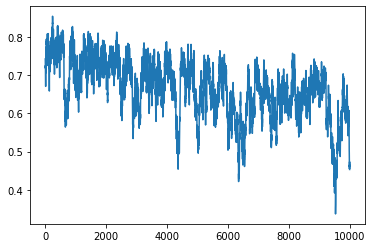

In [20]:
plt.plot(THETA[2,:])

In [16]:
def V(theta, w, D = 100):
    def sPath(theta, w):
        wPath = np.zeros(T)
        aPath = np.zeros(T)
        rPath = np.zeros(T)
        for t in range(T):
            c = np.random.normal(mu(theta, w), theta[3])
            while c < 0.0001 or c > w+y-0.0001:
                c = np.random.normal(mu(theta, w), theta[3])
            wPath[t] = w
            aPath[t] = c
            rPath[t] = np.log(c)*(beta**t)
            if np.random.uniform(0,1) > 0.5:
                w = (w+y-c) * (1+r)
            else:
                w = (w+y-c) * (1-r)
        return wPath, aPath, rPath
    value = 0
    for d in range(D):
        _,_,rp = sPath(theta,w)
        value += np.sum(rp)
    return value/D